# MLFlow Basics

This notebook provides a quick overview of machine learning model training with MLFlow Tracking

In [1]:
import mlflow
import numpy as np
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time
 
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
import warnings
warnings.filterwarnings('ignore')

import mlflow.spark
import os
import shutil
from pyspark.sql import SparkSession
from mlflow.tracking import MlflowClient
 


spark = (SparkSession.builder
            .config("spark.jars.packages", "org.mlflow:mlflow-spark:1.11.0")
            #.master("local[*]")
            .getOrCreate())

## Load data
The tutorial uses a dataset describing different wine samples. The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/)

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
red_wine= pd.read_csv(url+'winequality-red.csv', sep=";")
red_wine['is_red']=1.0
white_wine= pd.read_csv(url+'winequality-white.csv', sep=";")
white_wine['is_red']=0.0
data_df = pd.concat([red_wine,white_wine], axis=0)
data_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0


## Visualize Data

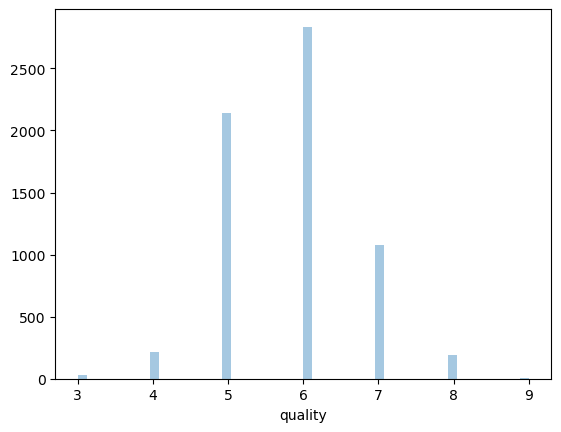

In [3]:
import seaborn as sns
sns.distplot(data_df.quality, kde=False)
plt.show()

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7.

In [4]:
data_label = data_df['quality'] >=7
data = data_df.drop(['quality'], axis=1)

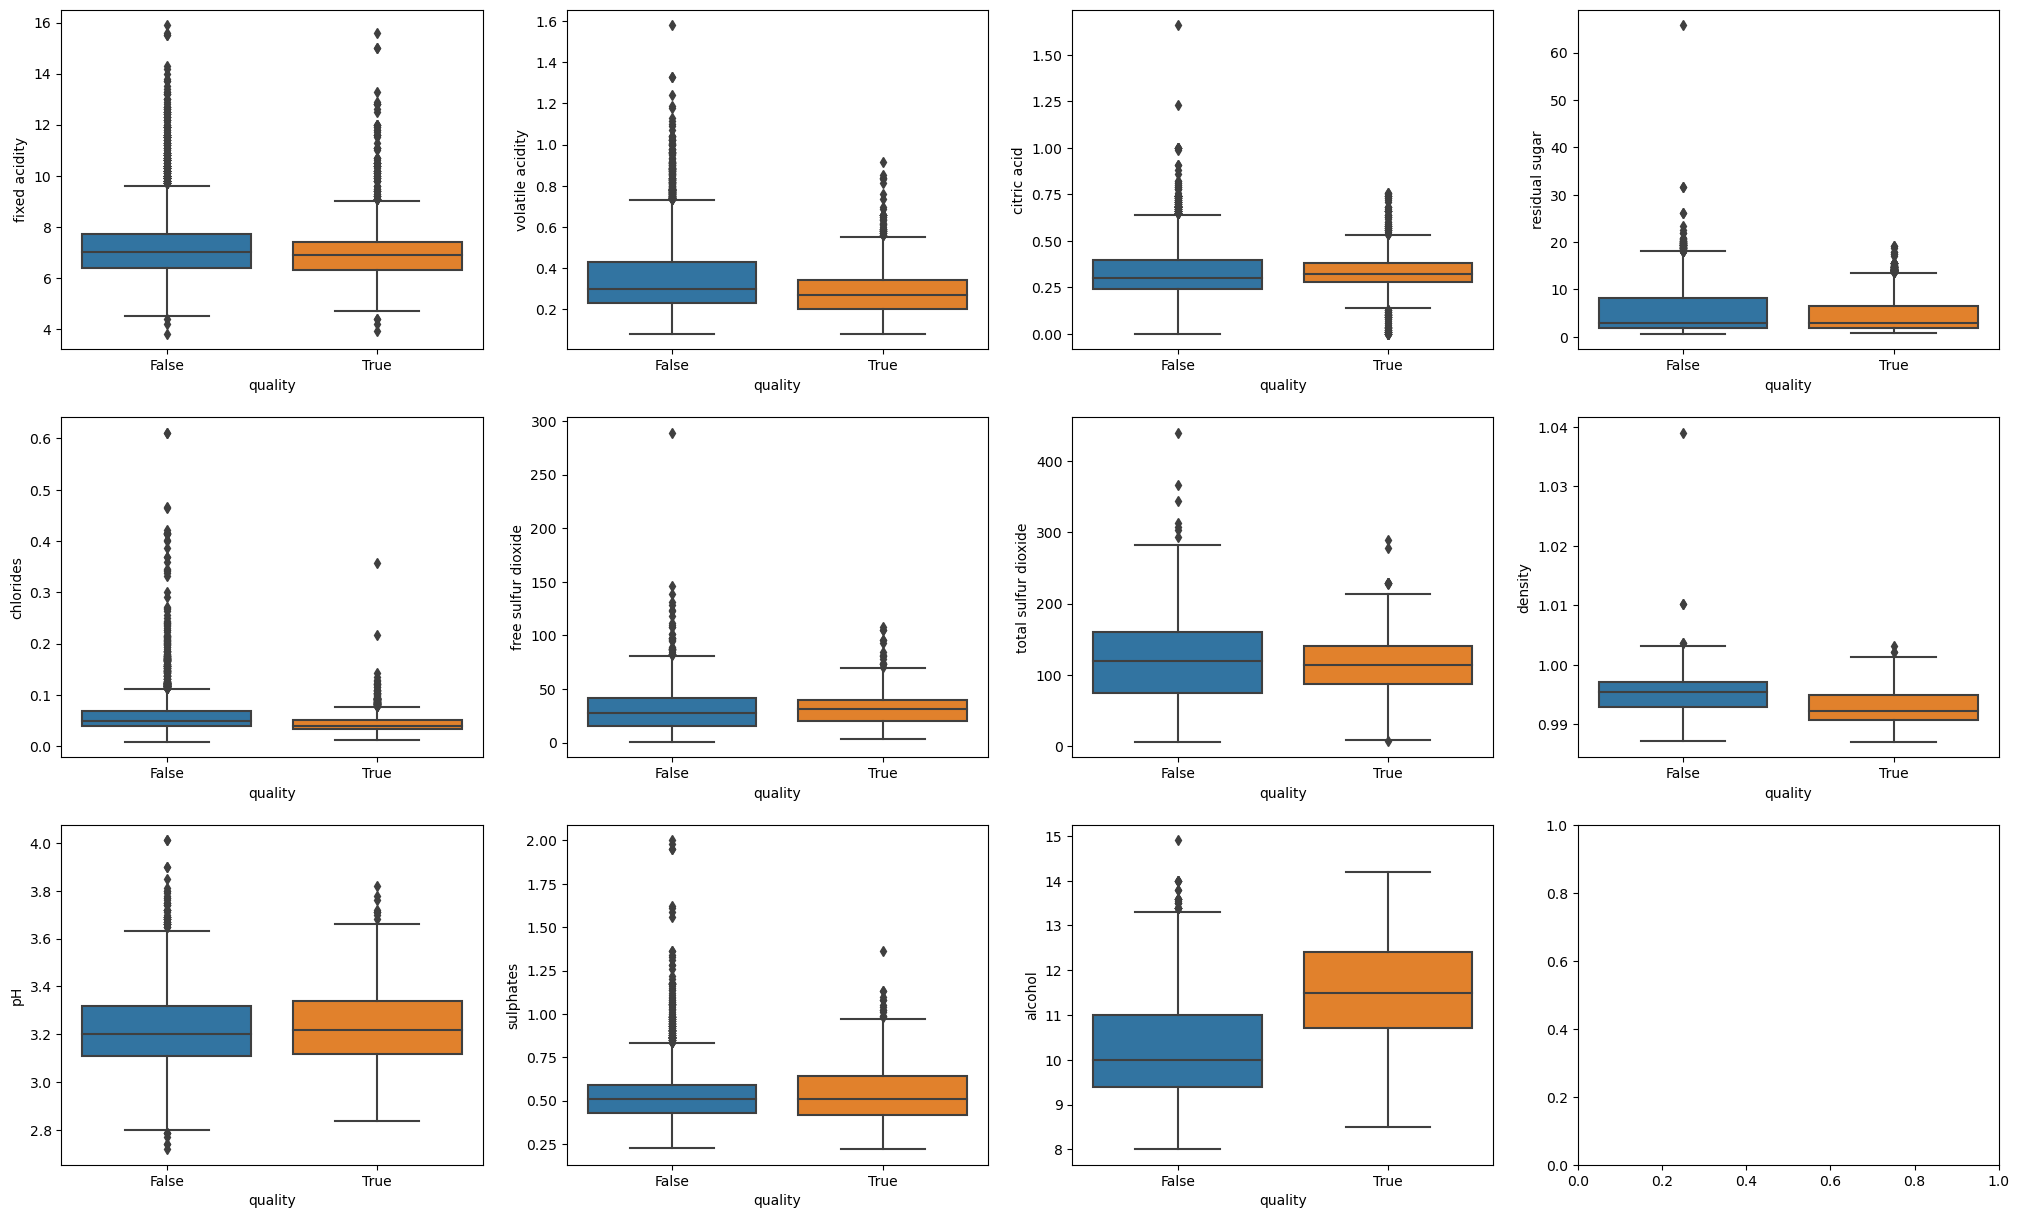

In [5]:

 
dims = (3, 4)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data_df.columns:
    if col == 'is_red' or col == 'quality':
        continue # Box plots cannot be used on indicator variables
    sns.boxplot(x=data_label, y=data[col], ax=axes[axis_i, axis_j])
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality.

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocess Data

In [6]:
data.isna().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
is_red                  False
dtype: bool

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, data_label, test_size=0.2, random_state=1)
 
# Split the remaining data equally into validation and test
#X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

In [15]:
mlflow.set_tracking_uri("http://host.docker.internal:5000")
client = MlflowClient("http://host.docker.internal:5000")

In [9]:
mlflow.autolog()

2022/12/12 08:28:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/12/12 08:28:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/12/12 08:28:16 INFO mlflow._spark_autologging: Autologging successfully enabled for spark.
2022/12/12 08:28:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/12/12 08:28:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [10]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        try :
            return self.model.predict_proba(model_input)[:,1]
        except AttributeError:
            return self.model.predict(model_input)

### GradientBoostClassifier

In [11]:
with mlflow.start_run(run_name='untuned_gradient_boost') as run:
    model = GradientBoostingClassifier(random_state=0, n_estimators =200)

    # Models, parameters, and training metrics are tracked automatically
    model.fit(X_train, y_train)

    predicted_probs = model.predict_proba(X_test)
    roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])

    # The AUC score on test data is not automatically logged, so log it manually
    mlflow.log_metric("test_auc", roc_auc)
    print("Test AUC of: {}".format(roc_auc))
    
    wrappedModel = SklearnModelWrapper(model)
    # Log the model with a signature that defines the schema of the model's inputs and outputs. 
    # When the model is deployed, this signature will be used to validate inputs.
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))

    # MLflow contains utilities to create a conda environment used to serve models.
    # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
    conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("gradient_boost_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

Test AUC of: 0.8664617051102332


In [12]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_gradient_boost"').iloc[0].run_id

In [13]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/gradient_boost", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...
2022/12/12 08:28:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 2
Created version '2' of model 'wine_quality'.


In [16]:
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

<ModelVersion: creation_timestamp=1670833702492, current_stage='Production', description='', last_updated_timestamp=1670833798674, name='wine_quality', run_id='a7a0ca7551884c87b60853a0acfe141f', run_link='', source='mlflow-artifacts:/0/a7a0ca7551884c87b60853a0acfe141f/artifacts/gradient_boost', status='READY', status_message='', tags={}, user_id='', version='2'>

### Random Forest Classifier

In [28]:
with mlflow.start_run(run_name='untuned_randomForest') as run:
    model_2 = RandomForestClassifier(random_state=0, n_estimators =200)

    # Models, parameters, and training metrics are tracked automatically
    model_2.fit(X_train, y_train)

    predicted_probs = model_2.predict_proba(X_test)
    roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])

    # The AUC score on test data is not automatically logged, so log it manually
    mlflow.log_metric("test_auc", roc_auc)
    print("Test AUC of: {}".format(roc_auc))
    
    wrappedModel = SklearnModelWrapper(model_2)
    # Log the model with a signature that defines the schema of the model's inputs and outputs. 
    # When the model is deployed, this signature will be used to validate inputs.
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))

    # MLflow contains utilities to create a conda environment used to serve models.
    # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
    conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

Test AUC of: 0.9121818051484645


In [29]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_randomForest"').iloc[0].run_id

In [30]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version_1 = mlflow.register_model(f"runs:/{run_id}/randomForest", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...
2022/12/12 08:31:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 3
Created version '3' of model 'wine_quality'.


In [31]:
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived",
)
client.transition_model_version_stage(
  name=model_name,
  version=model_version_1.version,
  stage="Production",
)

<ModelVersion: creation_timestamp=1670833895122, current_stage='Production', description='', last_updated_timestamp=1670833910197, name='wine_quality', run_id='eda1b934e9a24999aa425807bf563d5a', run_link='', source='mlflow-artifacts:/0/eda1b934e9a24999aa425807bf563d5a/artifacts/randomForest', status='READY', status_message='', tags={}, user_id='', version='3'>

### XGBoost Classifier

In [32]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb


with mlflow.start_run(run_name='untuned_xgboost'):
    mlflow.xgboost.autolog()
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_test, label=y_test)
    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    params = {
        'objective': 'binary:logistic',
        'metric': 'binary_logloss',
        'learning_rate': 0.01,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'feature_fraction': 0.9,
        'min_data_in_leaf': 20,
        'num_leaves': 41,
        'scale_pos_weight': 1.2,
        'lambda_l2': 1,
    }
    model_3 = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50, verbose_eval=0)
    validation_predictions = model_3.predict(validation)
    auc_score = roc_auc_score(y_test, validation_predictions)
    mlflow.log_metric('test_auc', auc_score)
    print("Test AUC of: {}".format(roc_auc))
    
    signature = infer_signature(X_train, model_3.predict(train))
    mlflow.xgboost.log_model(model_3, "model", signature=signature)

    

2022/12/12 08:31:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2022/12/12 08:31:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2022/12/12 08:31:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[08:31:50] WARNING: ../src/learner.cc:767: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "lambda_l2", "metric", "min_data_in_leaf", "num_leaves" } are not used.

Test AUC of: 0.9121818051484645


In [33]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_xgboost"').iloc[0].run_id

In [34]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version_2 = mlflow.register_model(f"runs:/{run_id}/xgboost", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...
2022/12/12 08:32:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 4
Created version '4' of model 'wine_quality'.


In [35]:
client.transition_model_version_stage(
  name=model_name,
  version=model_version_1.version,
  stage="Archived",
)
client.transition_model_version_stage(
  name=model_name,
  version=model_version_2.version,
  stage="Production",
)

<ModelVersion: creation_timestamp=1670833921230, current_stage='Production', description='', last_updated_timestamp=1670833936332, name='wine_quality', run_id='5b06108a0ff0467ea5e8311b6a96eaf6', run_link='', source='mlflow-artifacts:/0/5b06108a0ff0467ea5e8311b6a96eaf6/artifacts/xgboost', status='READY', status_message='', tags={}, user_id='', version='4'>

![MLFlow](./images/mlflow_gradientboost.png)

## Load models

In [36]:
# After a model has been logged, you can load it in different notebooks or jobs
# mlflow.pyfunc.load_model makes model prediction available under a common API
model_loaded = mlflow.pyfunc.load_model(
  'runs:/{run_id}/model'.format(
    run_id=run.info.run_id
  )
)
 
predictions_loaded = model_loaded.predict(X_test)
predictions_original = model_2.predict(X_test)
 
# The loaded model should match the original
assert(np.array_equal(predictions_loaded, predictions_original))

# Hyperparameter Tuning

## Hyperopt
Hyperopt is a Python library for hyperparameter tuning. 

In [50]:

# Define the search space to explore
search_space = {
  'n_estimators': scope.int(hp.quniform('n_estimators', 20, 1000, 1)),
  'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
}
 
def train_model(params):
    
    # Enable autologging on each worker
    #mlflow.autolog()
    with mlflow.start_run(run_name='inner_run', nested=True):
        model_hp = RandomForestClassifier(
          random_state=0,verbose=0,
          **params
        )
        model_hp.fit(X_train, y_train)
        predicted_probs = model_hp.predict_proba(X_test)
        # Tune based on the test AUC
        # In production settings, you could use a separate validation set instead
        roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
        mlflow.log_metric('test_auc', roc_auc)
        # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*roc_auc}
 
# SparkTrials distributes the tuning using Spark workers
# Greater parallelism speeds processing, but each hyperparameter trial has less information from other trials
# On smaller clusters or Databricks Community Edition try setting parallelism=2
#spark_trials = SparkTrials(
#  parallelism=8
#)
spark_trials =Trials() 
 
with mlflow.start_run(run_name='rf_hyperopt') as run:
  # Use hyperopt to find the parameters yielding the highest AUC
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=32,
    trials=spark_trials)

100%|██████████| 32/32 [04:20<00:00,  8.14s/trial, best loss: -0.8446261310054798]


In [51]:
import hyperopt
print(hyperopt.space_eval(search_space, best_params))

{'max_depth': 5, 'n_estimators': 370}


In [52]:
# Sort runs by their test auc; in case of ties, use the most recent run
best_run = mlflow.search_runs(
  order_by=['metrics.test_auc DESC', 'start_time DESC'],
  max_results=10,
).iloc[0]
print('Best Run')
print('AUC: {}'.format(best_run["metrics.test_auc"]))
print('Num Estimators: {}'.format(best_run["params.n_estimators"]))
print('Max Depth: {}'.format(best_run["params.max_depth"]))
print('Learning Rate: {}'.format(best_run["params.learning_rate"]))
 
best_model_pyfunc = mlflow.pyfunc.load_model(
  'runs:/{run_id}/model'.format(
    run_id=best_run.run_id
  )
)
best_model_predictions = best_model_pyfunc.predict(X_test[:5])
print("Test Predictions: {}".format(best_model_predictions))


Best Run
AUC: 0.9121818051484645
Num Estimators: 200
Max Depth: None


KeyError: 'params.learning_rate'

![MLFlow](./images/mlflow_compare.png)

In [45]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb
 
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}
 
def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
    mlflow.xgboost.autolog(log_models=False)
    with mlflow.start_run(nested=True):
        train = xgb.DMatrix(data=X_train, label=y_train)
        validation = xgb.DMatrix(data=X_test, label=y_test)
        # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
        # is no longer improving.
        booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                            evals=[(validation, "validation")], early_stopping_rounds=50, verbose_eval=0)
        validation_predictions = booster.predict(validation)
        auc_score = roc_auc_score(y_test, validation_predictions)
        mlflow.log_metric('auc', auc_score)

        signature = infer_signature(X_train, booster.predict(train))
        mlflow.xgboost.log_model(booster, "model", signature=signature)

    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}
 
# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = Trials()
 
# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
    best_params = fmin(
        fn=train_model, 
        space=search_space, 
        algo=tpe.suggest, 
        max_evals=96,
        trials=spark_trials,
    )

  0%|          | 0/96 [00:00<?, ?trial/s, best loss=?]

2022/12/12 08:39:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  1%|          | 1/96 [00:05<08:55,  5.64s/trial, best loss: -0.8866804192685104]

2022/12/12 08:39:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  2%|▏         | 2/96 [00:09<07:06,  4.54s/trial, best loss: -0.9058796355295018]

2022/12/12 08:39:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  3%|▎         | 3/96 [00:13<06:34,  4.24s/trial, best loss: -0.9058796355295018]

2022/12/12 08:39:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  4%|▍         | 4/96 [00:17<06:43,  4.38s/trial, best loss: -0.9058796355295018]

2022/12/12 08:39:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  5%|▌         | 5/96 [00:22<06:55,  4.56s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  6%|▋         | 6/96 [00:27<06:56,  4.62s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  7%|▋         | 7/96 [00:33<07:41,  5.19s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:13 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  8%|▊         | 8/96 [00:38<07:27,  5.09s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



  9%|▉         | 9/96 [00:42<06:36,  4.55s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 10%|█         | 10/96 [00:45<06:11,  4.32s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:25 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 11%|█▏        | 11/96 [00:49<05:52,  4.15s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:29 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 12%|█▎        | 12/96 [00:53<05:44,  4.10s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 14%|█▎        | 13/96 [00:57<05:34,  4.03s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 15%|█▍        | 14/96 [01:02<06:03,  4.43s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 16%|█▌        | 15/96 [01:07<05:52,  4.36s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 17%|█▋        | 16/96 [01:11<06:00,  4.50s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 18%|█▊        | 17/96 [01:16<05:47,  4.40s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:55 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 19%|█▉        | 18/96 [01:19<05:28,  4.21s/trial, best loss: -0.9106426022683829]

2022/12/12 08:40:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 20%|█▉        | 19/96 [01:24<05:24,  4.21s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:03 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 21%|██        | 20/96 [01:29<05:38,  4.45s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:08 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 22%|██▏       | 21/96 [01:33<05:24,  4.33s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 23%|██▎       | 22/96 [01:37<05:11,  4.22s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 24%|██▍       | 23/96 [01:41<05:10,  4.25s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 25%|██▌       | 24/96 [01:46<05:20,  4.45s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:26 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 26%|██▌       | 25/96 [01:51<05:41,  4.81s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 27%|██▋       | 26/96 [01:55<05:15,  4.50s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 28%|██▊       | 27/96 [01:59<04:55,  4.28s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 29%|██▉       | 28/96 [02:04<05:05,  4.50s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 30%|███       | 29/96 [02:08<04:42,  4.21s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 31%|███▏      | 30/96 [02:14<05:19,  4.84s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:54 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 32%|███▏      | 31/96 [02:19<05:25,  5.01s/trial, best loss: -0.9106426022683829]

2022/12/12 08:41:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 33%|███▎      | 32/96 [02:23<04:56,  4.63s/trial, best loss: -0.9106426022683829]

2022/12/12 08:42:03 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 34%|███▍      | 33/96 [02:27<04:38,  4.42s/trial, best loss: -0.9106426022683829]

2022/12/12 08:42:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 35%|███▌      | 34/96 [02:31<04:21,  4.22s/trial, best loss: -0.9106426022683829]

2022/12/12 08:42:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 36%|███▋      | 35/96 [02:35<04:14,  4.18s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 38%|███▊      | 36/96 [02:39<04:15,  4.26s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:19 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 39%|███▊      | 37/96 [02:43<04:07,  4.19s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 40%|███▉      | 38/96 [02:47<04:03,  4.19s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 41%|████      | 39/96 [02:52<04:08,  4.36s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 42%|████▏     | 40/96 [02:57<04:15,  4.56s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 43%|████▎     | 41/96 [03:01<04:03,  4.42s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 44%|████▍     | 42/96 [03:06<03:58,  4.41s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 45%|████▍     | 43/96 [03:11<03:59,  4.52s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 46%|████▌     | 44/96 [03:15<04:00,  4.63s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:55 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 47%|████▋     | 45/96 [03:20<03:49,  4.51s/trial, best loss: -0.9127771759908245]

2022/12/12 08:42:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 48%|████▊     | 46/96 [03:23<03:32,  4.24s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:03 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 49%|████▉     | 47/96 [03:27<03:18,  4.05s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 50%|█████     | 48/96 [03:31<03:09,  3.94s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 51%|█████     | 49/96 [03:35<03:13,  4.11s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 52%|█████▏    | 50/96 [03:39<03:02,  3.98s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 53%|█████▎    | 51/96 [03:43<03:04,  4.11s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 54%|█████▍    | 52/96 [03:47<03:03,  4.16s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 55%|█████▌    | 53/96 [03:52<03:04,  4.28s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 56%|█████▋    | 54/96 [03:56<02:53,  4.13s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 57%|█████▋    | 55/96 [04:00<02:50,  4.17s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 58%|█████▊    | 56/96 [04:05<02:58,  4.47s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 59%|█████▉    | 57/96 [04:11<03:08,  4.83s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 60%|██████    | 58/96 [04:17<03:24,  5.37s/trial, best loss: -0.9127771759908245]

2022/12/12 08:43:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 61%|██████▏   | 59/96 [04:21<03:02,  4.94s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:01 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 62%|██████▎   | 60/96 [04:25<02:44,  4.56s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 64%|██████▎   | 61/96 [04:30<02:43,  4.66s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 65%|██████▍   | 62/96 [04:36<02:52,  5.07s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 66%|██████▌   | 63/96 [04:42<03:00,  5.46s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 67%|██████▋   | 64/96 [04:47<02:48,  5.27s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 68%|██████▊   | 65/96 [04:52<02:35,  5.01s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 69%|██████▉   | 66/96 [04:57<02:33,  5.11s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 70%|██████▉   | 67/96 [05:01<02:20,  4.83s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 71%|███████   | 68/96 [05:06<02:18,  4.93s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 72%|███████▏  | 69/96 [05:10<02:06,  4.68s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 73%|███████▎  | 70/96 [05:14<01:55,  4.45s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:54 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 74%|███████▍  | 71/96 [05:18<01:48,  4.34s/trial, best loss: -0.9127771759908245]

2022/12/12 08:44:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 75%|███████▌  | 72/96 [05:27<02:13,  5.58s/trial, best loss: -0.9127771759908245]

2022/12/12 08:45:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 76%|███████▌  | 73/96 [05:31<01:54,  5.00s/trial, best loss: -0.9127771759908245]

2022/12/12 08:45:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 77%|███████▋  | 74/96 [05:36<01:51,  5.06s/trial, best loss: -0.9127771759908245]

2022/12/12 08:45:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 78%|███████▊  | 75/96 [05:40<01:40,  4.77s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 79%|███████▉  | 76/96 [05:45<01:39,  4.97s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:25 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 80%|████████  | 77/96 [05:50<01:32,  4.86s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 81%|████████▏ | 78/96 [05:54<01:25,  4.76s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 82%|████████▏ | 79/96 [05:58<01:16,  4.49s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 83%|████████▎ | 80/96 [06:02<01:07,  4.22s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 84%|████████▍ | 81/96 [06:06<01:01,  4.09s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 85%|████████▌ | 82/96 [06:10<00:57,  4.11s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 86%|████████▋ | 83/96 [06:14<00:54,  4.18s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:54 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 88%|████████▊ | 84/96 [06:18<00:50,  4.22s/trial, best loss: -0.9142267745635274]

2022/12/12 08:45:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 89%|████████▊ | 85/96 [06:22<00:45,  4.11s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 90%|████████▉ | 86/96 [06:26<00:40,  4.05s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:06 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 91%|█████████ | 87/96 [06:32<00:40,  4.48s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:11 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 92%|█████████▏| 88/96 [06:35<00:34,  4.27s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 93%|█████████▎| 89/96 [06:40<00:30,  4.35s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 94%|█████████▍| 90/96 [06:44<00:25,  4.28s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:24 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 95%|█████████▍| 91/96 [06:48<00:20,  4.20s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 96%|█████████▌| 92/96 [06:52<00:16,  4.17s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 97%|█████████▋| 93/96 [06:57<00:12,  4.22s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:36 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 98%|█████████▊| 94/96 [07:00<00:08,  4.01s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



 99%|█████████▉| 95/96 [07:04<00:04,  4.01s/trial, best loss: -0.9142267745635274]

2022/12/12 08:46:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.



100%|██████████| 96/96 [07:08<00:00,  4.46s/trial, best loss: -0.9142267745635274]


In [48]:
import hyperopt
print(hyperopt.space_eval(search_space, best_params))

{'learning_rate': 0.2234775117232957, 'max_depth': 86, 'min_child_weight': 1.0752397095509105, 'objective': 'binary:logistic', 'reg_alpha': 0.15906912636194329, 'reg_lambda': 0.00519602997324747, 'seed': 123}


## Search runs to retrieve the best model

In [57]:
# Sort runs by their test auc; in case of ties, use the most recent run
best_run = mlflow.search_runs(
  order_by=['metrics.test_auc DESC', 'start_time DESC'],
  max_results=10,
).iloc[0]
print('Best Run')
 
best_model_pyfunc = mlflow.pyfunc.load_model(
  'runs:/{run_id}/model'.format(
    run_id=best_run.run_id
  )
)
best_model_predictions = best_model_pyfunc.predict(X_test[:5])
print("Test Predictions: {}".format(best_model_predictions))


Best Run
Test Predictions: [False False False False False]


# Batch Inference

In [49]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)
# Replace <username> with your username before running this cell.
table_path = "./delta/wine_data"

spark_df.write.format("delta").save(table_path)

Py4JJavaError: An error occurred while calling o18506.save.
: java.lang.ClassNotFoundException: 
Failed to find data source: delta. Please find packages at
https://spark.apache.org/third-party-projects.html
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedToFindDataSourceError(QueryExecutionErrors.scala:587)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:675)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:725)
	at org.apache.spark.sql.DataFrameWriter.lookupV2Provider(DataFrameWriter.scala:864)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:256)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.ClassNotFoundException: delta.DefaultSource
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:587)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:520)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:661)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:661)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:661)
	... 16 more
